# Clustering via $k$-means

We previously studied the classification problem using the logistic regression algorithm. Since we had labels for each data point, we may regard the problem as one of _supervised learning_. However, in many applications, the data have no labels but we wish to discover possible labels (or other hidden patterns or structures). This problem is one of _unsupervised learning_. How can we approach such problems?

**Clustering** is one class of unsupervised learning methods. In this lab, we'll consider the following form of the clustering task. Suppose you are given

- a set of observations, $X \equiv \{\hat{x}_i \,|\, 0 \leq i < n\}$, and
- a target number of _clusters_, $k$.

Your goal is to partition the points into $k$ subsets, $C_0,\dots, C_{k-1} \subseteq X$, which are

- disjoint, i.e., $i \neq j \implies C_i \cap C_j = \emptyset$;
- but also complete, i.e., $C_0 \cup C_1 \cup \cdots \cup C_{k-1} = X$.

Intuitively, each cluster should reflect some "sensible" grouping. Thus, we need to specify what constitutes such a grouping.

## Setup: Dataset

The following cell will download the data you'll need for this lab. Run it now.

In [1]:
import requests
import os
import hashlib
import io

def on_vocareum():
    return os.path.exists('.voc')

def download(file, local_dir="", url_base=None, checksum=None):
    local_file = "{}{}".format(local_dir, file)
    print (local_file)
    if not os.path.exists(local_file):
        if url_base is None:
            url_base = "https://cse6040.gatech.edu/datasets/"
        url = "{}{}".format(url_base, file)
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(local_file, 'wb') as f:
            f.write(r.content)
            
    if checksum is not None:
        with io.open(local_file, 'rb') as f:
            body = f.read()
            body_checksum = hashlib.md5(body).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(local_file,
                                                                                           body_checksum,
                                                                                           checksum)
    print("'{}' is ready!".format(file))
    
if on_vocareum():
    URL_BASE = "https://cse6040.gatech.edu/datasets/kmeans/"
    DATA_PATH = "./resource/asnlib/publicdata/"
else:
    URL_BASE = "https://github.com/cse6040/labs-fa17/raw/master/datasets/kmeans/"
    DATA_PATH = ""

datasets = {'logreg_points_train.csv': '9d1e42f49a719da43113678732491c6d',
            'centers_initial_testing.npy': '8884b4af540c1d5119e6e8980da43f04',
            'compute_d2_soln.npy': '980fe348b6cba23cb81ddf703494fb4c',
            'y_test3.npy': 'df322037ea9c523564a5018ea0a70fbf',
            'centers_test3_soln.npy': '0c594b28e512a532a2ef4201535868b5',
            'assign_cluster_labels_S.npy': '37e464f2b79dc1d59f5ec31eaefe4161',
            'assign_cluster_labels_soln.npy': 'fc0e084ac000f30948946d097ed85ebc'}

for filename, checksum in datasets.items():
    download(filename, local_dir=DATA_PATH, url_base=URL_BASE, checksum=checksum)
    
print("\n(All data appears to be ready.)")



./resource/asnlib/publicdata/logreg_points_train.csv
'logreg_points_train.csv' is ready!
./resource/asnlib/publicdata/centers_initial_testing.npy
'centers_initial_testing.npy' is ready!
./resource/asnlib/publicdata/compute_d2_soln.npy
'compute_d2_soln.npy' is ready!
./resource/asnlib/publicdata/y_test3.npy
'y_test3.npy' is ready!
./resource/asnlib/publicdata/centers_test3_soln.npy
'centers_test3_soln.npy' is ready!
./resource/asnlib/publicdata/assign_cluster_labels_S.npy
'assign_cluster_labels_S.npy' is ready!
./resource/asnlib/publicdata/assign_cluster_labels_soln.npy
'assign_cluster_labels_soln.npy' is ready!

(All data appears to be ready.)


## The $k$-means clustering criterion

Here is one way to measure the quality of a set of clusters. For each cluster $C$, consider its center $\mu$ and measure the distance $\|x-\mu\|$ of each observation $x \in C$ to the center. Add these up for all points in the cluster; call this sum is the _within-cluster sum-of-squares (WCSS)_. Then, set as our goal to choose clusters that minimize the total WCSS over _all_ clusters.

More formally, given a clustering $C = \{C_0, C_1, \ldots, C_{k-1}\}$, let

$$
  \mathrm{WCSS}(C) \equiv \sum_{i=0}^{k-1} \sum_{x\in C_i} \|x - \mu_i\|^2,
$$

where $\mu_i$ is the center of $C_i$. This center may be computed simply as the mean of all points in $C_i$, i.e.,

$$
  \mu_i \equiv \dfrac{1}{|C_i|} \sum_{x \in C_i} x.
$$

Then, our objective is to find the "best" clustering, $C_*$, which is the one that has a minimum WCSS.

$$
  C_* = \arg\min_C \mathrm{WCSS}(C).
$$

## The standard $k$-means algorithm (Lloyd's algorithm)

Finding the global optimum is [NP-hard](https://en.wikipedia.org/wiki/NP-hardness), which is computer science mumbo jumbo for "we don't know whether there is an algorithm to calculate the exact answer in fewer steps than exponential in the size of the input." Nevertheless, there is an iterative method, Lloyd’s algorithm, that can quickly converge to a _local_ (as opposed to _global_) minimum. The procedure alternates between two operations: _assignment_ and _update_.

**Step 1: Assignment.** Given a fixed set of $k$ centers, assign each point to the nearest center:

$$
  C_i = \{\hat{x}: \| \hat{x} - \mu_i \| \le \| \hat{x} - \mu_j \|, 1 \le j \le k \}.
$$

**Step 2: Update.** Recompute the $k$ centers ("centroids") by averaging all the data points belonging to each cluster, i.e., taking their mean:

$$
  \mu_i = \dfrac{1}{|C_i|} \sum_{\hat{x} \in C_i} \hat{x}
$$

![Illustration of $k$-means](https://github.com/cse6040/labs-fa17/raw/master/lab14-kmeans/base21-small-transparent.png)

> Figure adapted from: http://stanford.edu/~cpiech/cs221/img/kmeansViz.png

In the code that follows, it will be convenient to use our usual "data matrix" convention, that is, each row of a data matrix $X$ is one of $m$ observations and each column (coordinate) is one of $d$ predictors. However, we will _not_ need a dummy column of ones since we are not fitting a function.

$$
  X
  \equiv \left(\begin{array}{c} \hat{x}_0^T \\ \vdots \\ \hat{x}_{m}^T \end{array}\right)
  = \left(\begin{array}{ccc} x_0 & \cdots & x_{d-1} \end{array}\right).
$$

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=100) # Adjust for higher-resolution figures

Matplotlib is building the font cache using fc-list. This may take a moment.


We will use the following data set, which is from the logistic regression notebook.

In [3]:
df = pd.read_csv(f'{DATA_PATH}logreg_points_train.csv')
df.head()

,x_1,x_2,label
0,-0.234443,-1.075960,1
1,0.730359,-0.918093,0
2,1.432270,-0.439449,0
3,0.026733,1.050300,0
4,1.879650,0.207743,0


Here are some descriptive statistics of the two classes:

In [4]:
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

print("=== Class 0 statistics ===")
display(df_class_0.describe())

print("\n=== Class 1 statistics ===")
display(df_class_1.describe())

=== Class 0 statistics ===


,x_1,x_2,label
count,195.000000,195.000000,195.0
mean,0.734464,0.239620,0.0
std,0.502728,0.947972,0.0
min,-0.526495,-2.522590,0.0
25%,0.405028,-0.280322,0.0
50%,0.700774,0.281831,0.0
75%,1.095340,0.845899,0.0
max,2.098110,2.506720,0.0



=== Class 1 statistics ===


,x_1,x_2,label
count,180.000000,180.000000,180.0
mean,-0.522413,-1.031378,1.0
std,0.182693,0.774145,0.0
min,-1.016560,-3.284610,1.0
25%,-0.637911,-1.601733,1.0
50%,-0.520604,-1.054165,1.0
75%,-0.408707,-0.448561,1.0
max,-0.000560,1.069520,1.0


You can observe that the centers are distinct, with "mean" or center-coordinates of $\approx (0.734, 0.240)$ for class 0 versus $\approx (-0.522, -1.031)$ for class 1.

If you are a more visual person, here is a plot that makes the same point:

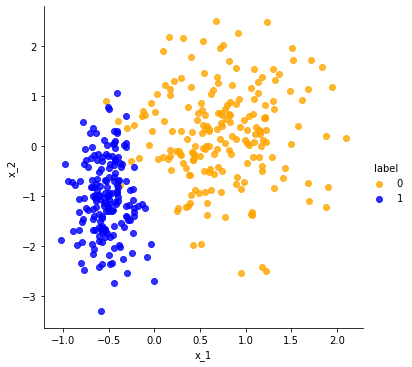

In [5]:
from nb13utils import make_scatter_plot, mark_matches, count_matches

make_scatter_plot(df)

Let's extract the data points as a data matrix, `points`, and the labels as a vector, `labels`. Note that the k-means algorithm you will implement should **not** reference `labels` -- that's the solution we will try to predict given only the point coordinates (`points`) and target number of clusters (`k`).

In [7]:
points = df[['x_1', 'x_2']].values
labels = df['label'].values
n, d = points.shape
k = 2

Note that the labels should _not_ be used in the $k$-means algorithm. We use them here only as ground truth for later verification.

### How to start? Initializing the $k$ centers

To start the algorithm, you need an initial guess. Let's randomly choose $k$ observations from the data.

**Exercise 1** (2 points). Complete the following function, `init_centers(X, k)`, so that it randomly selects $k$ of the given observations to serve as centers. It should return a Numpy array of size `k`-by-`d`, where `d` is the number of columns of `X`.

In [20]:
def init_centers(X, k):
    """
    Randomly samples k observations from X as centers.
    Returns these centers as a (k x d) numpy array.
    """
    index_sample = np.random.choice(len(X), size=k, replace=False)
    return X[index_sample, :]


In [21]:
# Test cell: `init_centers_test`

centers_initial = init_centers(points, k)
print("Initial centers:\n", centers_initial)

assert type(centers_initial) is np.ndarray, "Your function should return a Numpy array instead of a {}".format(type(centers_initial))
assert centers_initial.shape == (k, d), "Returned centers do not have the right shape ({} x {})".format(k, d)
assert (sum(centers_initial[0, :] == points) == [1, 1]).all(), "The centers must come from the input."
assert (sum(centers_initial[1, :] == points) == [1, 1]).all(), "The centers must come from the input."

print("\n(Passed!)")

Initial centers:
 [[-0.686548 -1.9473  ]
 [-0.578478 -3.28461 ]]

(Passed!)


### Computing the distances

**Exercise 2** (3 points). Implement a function that computes a distance matrix, $S = (s_{ij})$ such that $s_{ij} = d_{ij}^2$ is the _squared_ distance from point $\hat{x}_i$ to center $\mu_j$. It should return a Numpy matrix `S[:m, :k]`.

In [25]:
def compute_d2(X, centers):
    m = len(X)
    k = len(centers)
    
    S = np.empty((m, k))
    
    for i in range(m):
        S[i,:] = np.linalg.norm(X[i,:] - centers, ord=2, axis=1)**2
        
    return S


In [26]:
# Test cell: `compute_d2_test`

centers_initial_testing = np.load("{}centers_initial_testing.npy".format(DATA_PATH))
compute_d2_soln = np.load("{}compute_d2_soln.npy".format(DATA_PATH))

S = compute_d2 (points, centers_initial_testing)
assert (np.linalg.norm (S - compute_d2_soln, axis=1) <= (20.0 * np.finfo(float).eps)).all ()

print("\n(Passed!)")


(Passed!)


**Exercise 3** (2 points). Write a function that uses the (squared) distance matrix to assign a "cluster label" to each point.

That is, consider the $m \times k$ squared distance matrix $S$. For each point $i$, if $s_{i,j}$ is the minimum squared distance for point $i$, then the index $j$ is $i$'s cluster label. In other words, your function should return a (column) vector $y$ of length $m$ such that

$$
  y_i = \underset{j \in \{0, \ldots, k-1\}}{\operatorname{argmin}} s_{ij}.
$$

> Hint: Judicious use of Numpy's [`argmin()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html) makes for a nice one-line solution.

In [28]:
def assign_cluster_labels(S):
    return np.argmin(S, axis=1)

# Cluster labels:     0    1
S_test1 = np.array([[0.3, 0.2],  # --> cluster 1
                    [0.1, 0.5],  # --> cluster 0
                    [0.4, 0.2]]) # --> cluster 1
y_test1 = assign_cluster_labels(S_test1)
print("You found:", y_test1)

assert (y_test1 == np.array([1, 0, 1])).all()

You found: [1 0 1]


In [29]:
# Test cell: `assign_cluster_labels_test`

S_test2 = np.load("{}assign_cluster_labels_S.npy".format(DATA_PATH))
y_test2_soln = np.load("{}assign_cluster_labels_soln.npy".format(DATA_PATH))
y_test2 = assign_cluster_labels(S_test2)
assert (y_test2 == y_test2_soln).all()

print("\n(Passed!)")


(Passed!)


**Exercise 4** (2 points). Given a clustering (i.e., a set of points and assignment of labels), compute the center of each cluster.

In [52]:
def update_centers(X, y):
    # X[:m, :d] == m points, each of dimension d
    # y[:m] == cluster labels
    m, d = X.shape
    k = max(y) + 1
    assert m == len(y)
    assert (min(y) >= 0)
    
    centers = np.empty((k, d))
    for j in range(k):
        # Compute the new center of cluster j,
        # i.e., centers[j, :d].
        centers[j,:] = np.mean(X[y == j, :], axis = 0)
    return centers

In [53]:
# Test cell: `update_centers_test`

y_test3 = np.load("{}y_test3.npy".format(DATA_PATH))
centers_test3_soln = np.load("{}centers_test3_soln.npy".format(DATA_PATH))
centers_test3 = update_centers(points, y_test3)

delta_test3 = np.abs(centers_test3 - centers_test3_soln)
assert (delta_test3 <= 2.0*len(centers_test3_soln)*np.finfo(float).eps).all()

print("\n(Passed!)")


(Passed!)


**Exercise 5** (2 points). Given the squared distances, return the within-cluster sum of squares.

In particular, your function should have the signature,

```python
    def WCSS(S):
        ...
```

where `S` is an array of distances as might be computed from Exercise 2.

For example, suppose `S` is defined as follows:

```python
    S = np.array([[0.3, 0.2],
                  [0.1, 0.5],
                  [0.4, 0.2]])
```

Then `WCSS(S) == 0.2 + 0.1 + 0.2 == 0.5.`

> _Hint_: See [numpy.amin](https://docs.scipy.org/doc/numpy/reference/generated/numpy.amin.html#numpy.amin).

In [54]:
def WCSS(S):
    return np.sum(np.amin(S, axis=1))
    
# Quick test:
print("S ==\n", S_test1)
WCSS_test1 = WCSS(S_test1)
print("\nWCSS(S) ==", WCSS(S_test1))

S ==
 [[0.3 0.2]
 [0.1 0.5]
 [0.4 0.2]]

WCSS(S) == 0.5


In [55]:
# Test cell: `WCSS_test`

assert np.abs(WCSS_test1 - 0.5) <= 3.0*np.finfo(float).eps, "WCSS(S_test1) should be close to 0.5, not {}".format(WCSS_test1)
print("\n(Passed!)")


(Passed!)


Lastly, here is a function to check whether the centers have "moved," given two instances of the center values. It accounts for the fact that the order of centers may have changed.

In [56]:
def has_converged(old_centers, centers):
    return set([tuple(x) for x in old_centers]) == set([tuple(x) for x in centers])

**Exercise 6** (3 points). Put all of the preceding building blocks together to implement Lloyd's $k$-means algorithm.

In [61]:
def kmeans(X, k,
           starting_centers=None,
           max_steps=np.inf):
    if starting_centers is None:
        centers = init_centers(X, k)
    else:
        centers = starting_centers
        
    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_centers = centers
        S_new = compute_d2(X, old_centers)
        labels = assign_cluster_labels(S_new)
        centers = update_centers(X, labels)
        converged = has_converged(old_centers, centers)
        print ("iteration", i, "WCSS = ", WCSS (S))
        i += 1
    return labels

clustering = kmeans(points, k, starting_centers=points[[5, 255], :], max_steps=500)

iteration 1 WCSS =  573.9274414572508
iteration 2 WCSS =  573.9274414572508
iteration 3 WCSS =  573.9274414572508
iteration 4 WCSS =  573.9274414572508
iteration 5 WCSS =  573.9274414572508
iteration 6 WCSS =  573.9274414572508
iteration 7 WCSS =  573.9274414572508


Let's visualize the results.

329 matches out of 375 possible (~ 87.7%)


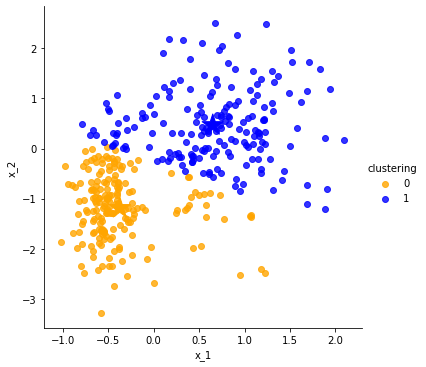

In [62]:
# Test cell: `kmeans_test`

df['clustering'] = clustering
centers = update_centers(points, clustering)
make_scatter_plot(df, hue='clustering', centers=centers)

n_matches = count_matches(df['label'], df['clustering'])
print(n_matches,
      "matches out of",
      len(df), "possible",
      "(~ {:.1f}%)".format(100.0 * n_matches / len(df)))

assert n_matches >= 320

**Applying k-means to an image.** In this section of the notebook, you will apply k-means to an image, for the purpose of doing a "stylized recoloring" of it. (You can view this example as a primitive form of [artistic style transfer](http://genekogan.com/works/style-transfer/), which state-of-the-art methods today [accomplish using neural networks](https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199).)

In particlar, let's take an input image and cluster pixels based on the similarity of their colors. Maybe it can become the basis of your own [Instagram filter](https://blog.hubspot.com/marketing/instagram-filters)!

Shape of the matrix obtained by reading the image
(412, 620, 3)


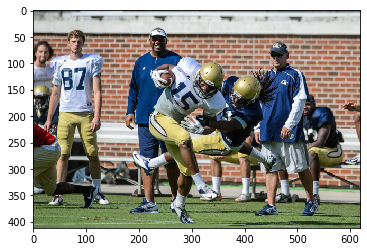

In [63]:
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

def read_img(path):
    """
    Read image and store it as an array, given the image path. 
    Returns the 3 dimensional image array.
    """
    img = Image.open(path)
    img_arr = np.array(img, dtype='int32')
    img.close()
    return img_arr

def display_image(arr):
    """
    display the image
    input : 3 dimensional array
    """
    arr = arr.astype(dtype='uint8')
    img = Image.fromarray(arr, 'RGB')
    imshow(np.asarray(img))
    

img_arr = read_img(f"{DATA_PATH}/football.bmp")
display_image(img_arr)
print("Shape of the matrix obtained by reading the image")
print(img_arr.shape)

Note that the image is stored as a "3-D" matrix. It is important to understand how matrices help to store a image. Each pixel corresponds to a intensity value for Red, Green and Blue. If you note the properties of the image, its resolution is 620 x 412. The image width is 620 pixels and height is 412 pixels, and each pixel has three values - **R**, **G**, **B**. This makes it a 412 x 620 x 3 matrix.

**Exercise 7** (1 point). Write some code to *reshape* the matrix into "img_reshaped" by transforming "img_arr" from a "3-D" matrix to a flattened "2-D" matrix which has 3 columns corresponding to the RGB values for each pixel. In this form, the flattened matrix must contain all pixels and their corresponding RGB intensity values. Remember in the previous modules we had discussed a C type indexing style and a Fortran type indexing style. In this problem, refer to the C type indexing style. The numpy reshape function may be of help here.

In [90]:
img_reshaped = img_arr.flatten().reshape(412*620, 3)
#print(img_reshaped[:5])

[[76 84 87]
 [73 81 84]
 [68 76 79]
 [63 71 74]
 [58 66 69]]


In [80]:
# Test cell - 'reshape_test'
r, c, l = img_arr.shape
# The reshaped image is a flattened '2-dimensional' matrix
assert len(img_reshaped.shape) == 2
r_reshaped, c_reshaped = img_reshaped.shape
assert r * c * l == r_reshaped * c_reshaped
assert c_reshaped == 3
print("Passed")

Passed


**Exercise 8** (1 point). Now use the k-means function that you wrote above to divide the image in **3** clusters. The result would be a vector named labels, which assigns the label to each pixel.

In [81]:
labels = kmeans(img_reshaped, k=3, starting_centers=None, max_steps=10)

iteration 1 WCSS =  573.9274414572508
iteration 2 WCSS =  573.9274414572508
iteration 3 WCSS =  573.9274414572508
iteration 4 WCSS =  573.9274414572508
iteration 5 WCSS =  573.9274414572508
iteration 6 WCSS =  573.9274414572508
iteration 7 WCSS =  573.9274414572508
iteration 8 WCSS =  573.9274414572508
iteration 9 WCSS =  573.9274414572508
iteration 10 WCSS =  573.9274414572508


In [75]:
# Test cell - 'labels'
assert len(labels) == r_reshaped
assert set(labels) == {0, 1, 2}
print("\nPassed!")


Passed!


**Exercise 9** (2 points). Write code to calculate the mean of each cluster and store it in a dictionary, named centers, as label:array(cluster_center). For 3 clusters, the dictionary should have three keys as the labels and their corresponding cluster centers as values, i.e. {0:array(center0), 1: array(center1), 2:array(center2)}.

In [86]:
centers_array = update_centers(img_reshaped, labels)
centers = {}
for j,values in enumerate(centers_array):
    centers[j] = values
#print(centers)

{0: array([203.26985036, 200.09357663, 194.36010587]), 1: array([39.65883336, 46.21978981, 48.93580841]), 2: array([136.40802368, 126.99533315, 103.31016463])}


In [87]:
print("Free points here! But you need to implement the above section correctly for you to see what we want you to see later.")
print("\nPassed!")

Free points here! But you need to implement the above section correctly for you to see what we want you to see later.

Passed!


Below, we have written code to generate a matrix "img_clustered" of the same dimensions as img_reshaped, where each pixel is replaced by the cluster center to which it belongs.

In [88]:
img_clustered = np.array([centers[i] for i in labels])

Let us display the clustered image and see how kmeans works on the image.

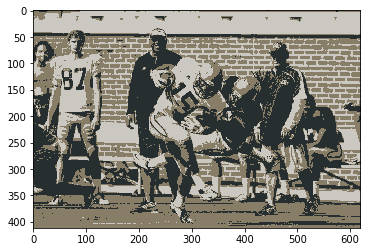

In [89]:
r, c, l = img_arr.shape
img_disp = np.reshape(img_clustered, (r, c, l), order="C")
display_image(img_disp)

You can visually inspect the original image and the clustered image to get a sense of what kmeans is doing here. You can also try to vary the number of clusters to see how the output image changes

## Built-in $k$-means

The preceding exercises walked you through how to implement $k$-means, but as you might have imagined, there are existing implementations as well! The following shows you how to use Scipy's implementation, which should yield similar results. If you are asked to use $k$-means in a future lab (or exam!), you can use this one.

In [91]:
from scipy.cluster import vq

Centers:
 [[ 0.64980076  0.4667703 ]
 [-0.37382602 -1.18565619]]

Compare with your method:
 {0: array([203.26985036, 200.09357663, 194.36010587]), 1: array([39.65883336, 46.21978981, 48.93580841]), 2: array([136.40802368, 126.99533315, 103.31016463])} 

Distortion (WCSS): 0.7508945219289553
329 matches out of 375 possible (~ 87.7%)


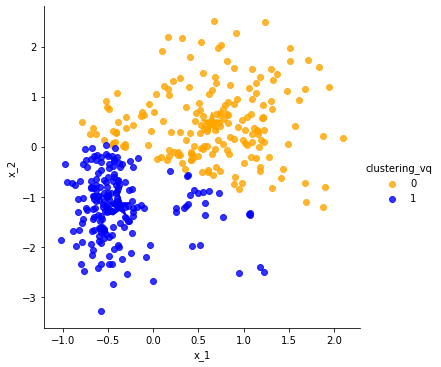

In [92]:
# `distortion` below is the similar to WCSS.
# It is called distortion in the Scipy documentation
# since clustering can be used in compression.
k = 2
centers_vq, distortion_vq = vq.kmeans(points, k)

# vq return the clustering (assignment of group for each point)
# based on the centers obtained by the kmeans function.
# _ here means ignore the second return value
clustering_vq, _ = vq.vq(points, centers_vq)

print("Centers:\n", centers_vq)
print("\nCompare with your method:\n", centers, "\n")
print("Distortion (WCSS):", distortion_vq)

df['clustering_vq'] = clustering_vq
make_scatter_plot(df, hue='clustering_vq', centers=centers_vq)

n_matches_vq = count_matches(df['label'], df['clustering_vq'])
print(n_matches_vq,
      "matches out of",
      len(df), "possible",
      "(~ {:.1f}%)".format(100.0 * n_matches_vq / len(df)))

**Fin!** That marks the end of this notebook. Don't forget to submit it!